In [1]:
import nibabel as nib
import nibabel.processing
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import random
from skimage.filters import gabor
import skimage.exposure
import SimpleITK as sitk
import scipy.ndimage  # Per il resize volumetrico



# ANALISI DEI METADATI DEI FILE NII
## Prima di effettuare delle operazioni sui file nii, verifica se la distanza tra le slide sia inferiore al millimetro e verifica se lo spazio dei voxel sia lo stesso (Es: 0.5,0.5,0.5)

In [ ]:
# ANALISI METADATI DEI FILE NII
import nibabel as nib

# Percorso del file NIfTI
nii_path = "D:\StefanoTesiMagistrale\DatasetStefano\MSSEG-Training\Training\TrainingFlairNII\TrainANii\center_01_sub_01_FLAIR_preprocessed.nii"  # <-- modifica con il tuo percorso

# Carica immagine e header
img = nib.load(nii_path)
header = img.header
affine = img.affine
print(header)
# Estrai informazioni

shape = img.shape
voxel_spacing = header.get_zooms()  # es. (1.0, 1.0, 1.0)

slice_spacing = voxel_spacing[2] if len(voxel_spacing) >= 3 else "Non disponibile"
data_type = header.get_data_dtype()

# Stampa
print(f"🧠 File: {nii_path}")
print(f"Forma volume (x, y, z): {shape}")
print(f"Datatype: {data_type}")
print(f"Voxel spacing (x, y, z): {voxel_spacing}")
print(f"➡️  Distanza tra le slice (asse Z): {slice_spacing} mm")
print(f"\nMatrice affine:\n{affine}")


In [ ]:
#PER IMMAGINE SINGOLA

# Carica volume
vol = nib.load(r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANii\center_01_sub_01_FLAIR_preprocessed.nii").get_fdata()

# Seleziona una singola slice
slice_index = 350
slice_data = vol[:, :, slice_index]

# Clipping tra 1° e 99° percentile
v_min, v_max = np.percentile(slice_data, (1, 99))
clipped = np.clip(slice_data, v_min, v_max)

# Normalizzazione tra 0 e 1
normalized = (clipped - v_min) / (v_max - v_min)

# Visualizza la slice
plt.imshow(normalized, cmap='gray', interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# === Parametri ===
input_path = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANii\center_01_sub_01_FLAIR_preprocessed.nii"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlair\TrainA"

# Crea la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)

# Carica il volume
vol = nib.load(input_path).get_fdata()

# Itera su tutte le slice lungo l'asse Z
for i in range(vol.shape[2]):
    slice_data = vol[:, :, i]

    # Salta slice completamente nere o quasi (tutti zeri o valore costante)
    if np.std(slice_data) < 1e-6:
        continue

    # Clipping tra 1° e 99° percentile
    v_min, v_max = np.percentile(slice_data, (1, 99))
    if np.abs(v_max - v_min) < 1e-6:
        continue

    clipped = np.clip(slice_data, v_min, v_max)

    # Normalizzazione tra 0 e 1
    normalized = (clipped - v_min) / (v_max - v_min)

    # Salva la slice come PNG
    output_path = os.path.join(output_folder, f"slice_{i:03d}.png")
    plt.imsave(output_path, normalized, cmap='gray')

print("✅ Slice significative salvate con successo.")


# TARGET SPACING DEL VOLUME in (0.5,0.5,0.5)
# Questo vale anche nel caso in cui si vuole avere un target_space di 1,2,ecc...

Questo codice serve nel caso in cui, visualizzando lo spazio di un voxel, non abbiamo la stessa misura su tutti e 3 gli assi (x,y,z) (Ad esempio: (1,0.5,0.5)). In questo caso si utilizza questo codice che crea degli zooming factor dividendo il corrente voxel spacing originale per lo spacing target.
Facendo la *divisione* tra gli space voxels e gli zooming factor otterrai lo space target.

## Esempio
Supponi di avere uno spazio di voxel pari a *(1,0.5,0.5)* e supponi che hai un target space di *(0.5)* . Allora gli zooming factors saranno pari a:
- 1/0.5 = 0.5
- 0.5/0.5 = 1
- 0.5/0.1 = 1



In [ ]:
import os
import numpy as np
import nibabel as nib
from nibabel.processing import resample_to_output
import matplotlib.pyplot as plt
# PER UN SINGOLO FILE

# === Parametri ===
input_path = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANiiZscore\center_01_sub_01_FLAIR_preprocessed_zscore.nii"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANiiZscore\CervelloPostZ-Score"
target_spacing = (0.5, 0.5, 0.5)

# Crea la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)

# Carica immagine NIfTI
img = nib.load(input_path)
print("Voxel spacing originale:", img.header.get_zooms())

# Esegui resampling a voxel isotropi (0.5, 0.5, 0.5)
resampled_img = resample_to_output(img, voxel_sizes=target_spacing)
resampled_data = resampled_img.get_fdata()
print("Nuova forma volume:", resampled_data.shape)

# Itera su tutte le slice lungo l'asse Z
for i in range(resampled_data.shape[2]):
    slice_data = resampled_data[:, :, i]

    # Scarta slice completamente nere o quasi
    if np.std(slice_data) < 1e-6:
        continue
    # Eventuale clipping "dolce" per visualizzazione (es: da -3 a +3 deviazioni standard)
    clipped = np.clip(slice_data, -3, 3)

    # Riscalamento per la visualizzazione tra 0 e 1
    vis_data = (clipped + 3) / 6
    # Salvataggio
    output_path = os.path.join(output_folder, f"slice_{i:03d}.png")
    plt.imsave(output_path, vis_data, cmap='gray')

print("✅ Tutte le slice salvate con voxel isotropici.")


In [ ]:
import os
import numpy as np
import nibabel as nib
from nibabel.processing import resample_to_output
import matplotlib.pyplot as plt
# PER CONSIDERARE L'INTERA CARTELLA

# === Parametri ===
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainBNii"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlair\TrainB"
target_spacing = (0.5, 0.5, 0.5)

# Crea la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)

# Itera su tutti i file .nii nella cartella
for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(os.path.splitext(filename)[0])[0]  # per .nii o .nii.gz

        print(f"📂 Processing: {filename}")
        img = nib.load(input_path)
        print("  Voxel spacing originale:", img.header.get_zooms())

        # Resampling
        resampled_img = resample_to_output(img, voxel_sizes=target_spacing)
        resampled_data = resampled_img.get_fdata()
        print("  Nuova forma:", resampled_data.shape)

        for i in range(resampled_data.shape[2]):
            slice_data = resampled_data[:, :, i]

            if np.std(slice_data) < 1e-6:
                continue

            v_min, v_max = np.percentile(slice_data, (1, 99))
            if np.abs(v_max - v_min) < 1e-5:
                continue

            clipped = np.clip(slice_data, v_min, v_max)
            normalized = (clipped - v_min) / (v_max - v_min)

            # Output path: slice associata al file di origine
            output_path = os.path.join(output_folder, f"{base_name}_slice{i:03d}.png")
            plt.imsave(output_path, normalized, cmap='gray')

print("✅ Completato: tutte le immagini elaborate e salvate.")


# Estrazione Z-score dai volumi delle immagini
## Allora, dopo estenuanti ricerche si è riusciti ad arrivare alla conclusion.
### In questo codice vengono effettuati i seguenti passaggi:
- Apertura di un file nii preso da una cartella di un file;
- Trasformazione della dimensione dei voxel dell'immagine di input con annessa interpolazione nearest neighbor;
- Calcolo dello Z-Score del nifti trasformato;
- Applicazione dello Z-score al nifti trasformato per effettuare normalizzazione;
- Salvataggio del nuovo file normalizzato in un file nifti

(144, 512, 512)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 144 512 512   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        1.0999999 0.5       0.5       0.        0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : aligned
sform_code      : scanner
quatern_b       : 0.03051496
quatern_c       : 0.0011989537
quate

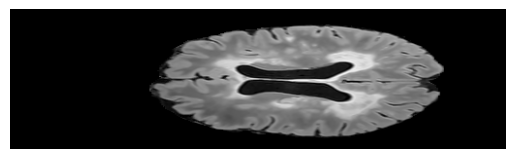

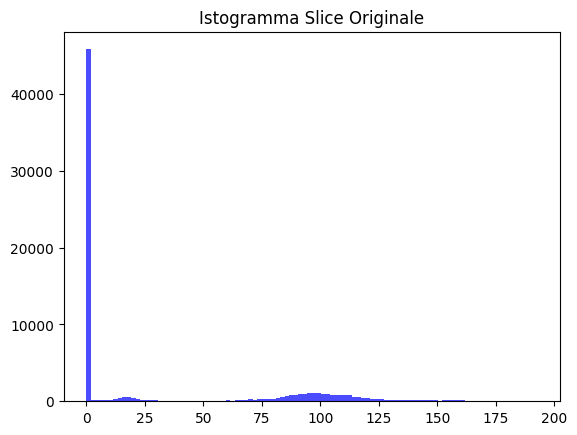

  Voxel spacing originale: (np.float32(1.0999999), np.float32(0.5), np.float32(0.5))
  Nuova forma: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 386 538 531   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  0.5 0.5 0.5 1.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
q

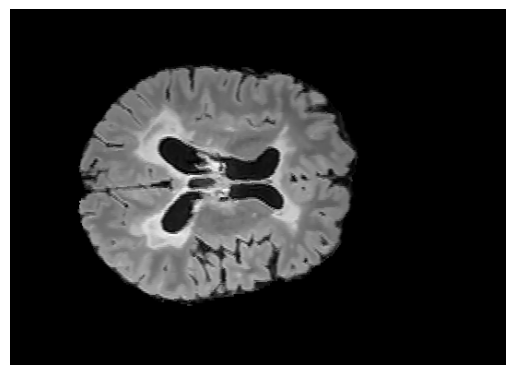

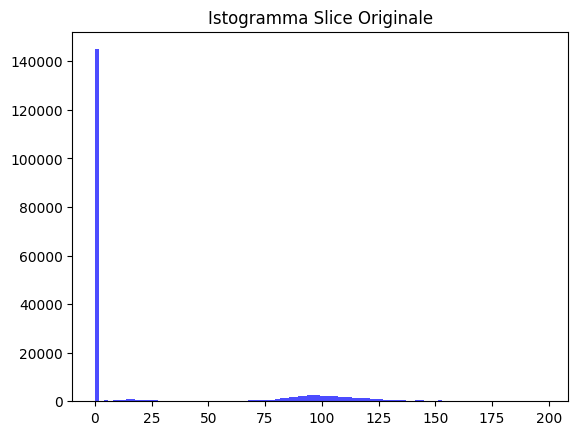

maschera [ 2.95069647  7.88024664  3.37900376 ...  6.695539   10.51134872
  7.06007719]
media del volume:  91.09627247004329
deviazione standard del volume:  35.954877034766454
z_score:  [-2.45156105 -2.31445725 -2.43964869 ... -2.3474071  -2.24127936
 -2.33726833]
tipo z_score:  <class 'numpy.ndarray'>


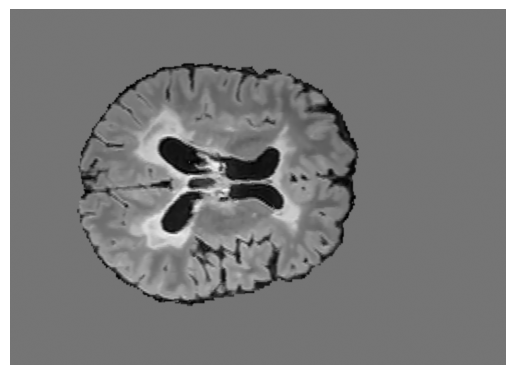

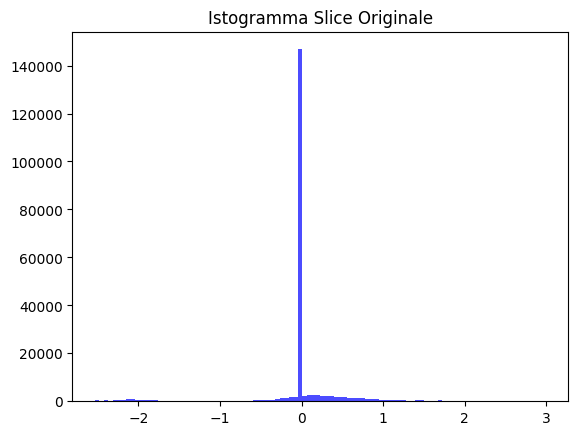

In [3]:
# PER SINGOLO FILE

import nibabel as nib
from nibabel.processing import resample_to_output
import os

# Percorso al file NIfTI di input
input_file = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANii\center_01_sub_01_FLAIR_preprocessed.nii" # <-- Cambia con il percorso reale


# Cartella di output
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANiiZscore"

# ESTRAZIONE DELL'IMMAGINE DI TIPO NIFTI
img = nib.load(input_file)
data = img.get_fdata()
header_1 = img.header
print(data.shape)
print(header_1)
mask = data != 0
print(mask)
slice_index = 340
slice_data = data[:, :, slice_index]

# Visualizza la slice
plt.imshow(slice_data, cmap='gray', interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()


plt.hist(slice_data.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Originale")
plt.show()

# CAMBIO DEI VOXEL SPACING, CON CONSEGUENTE RITRASFORMAZIONE DELL'IMMAGINE
target_spacing = (0.5, 0.5, 0.5)
header = img.header
voxel_spacing = header.get_zooms()  # es. (1.0, 1.0, 1.0)
print(f"  Voxel spacing originale:", voxel_spacing)
# SLICES RICAMPIONATE
resampled_img = resample_to_output(img, target_spacing, order = 0) # resampling con interpolazione nearest neigh.

# ESTRAZIONE DEI DATI DAL RICAMPIONAMENTO

resampled_data = resampled_img.get_fdata()
print(f"  Nuova forma:", resampled_img.header)
print(f"  Nuova matrice:", resampled_data)

resampled_slice = resampled_data[:,:,slice_index]

# Visualizza la slice
plt.imshow(resampled_slice, cmap='gray', interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()
# Istogramma
plt.hist(resampled_slice.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Originale")
plt.show()


# DA QUI, CALCOLO DELLO Z-SCORE DELL'IMMAGINE TRASFORMATA
mask_resampled = resampled_data != 0 # maschera, levo gli 0 dalle slice
print("maschera", resampled_data[mask_resampled])

media = np.mean(resampled_data[mask_resampled]) # media su tutto il volume
print("media del volume: ",media)

std = np.std(resampled_data[mask_resampled]) # deviazione su tutto il volume
print("deviazione standard del volume: ", std)

z_score = (resampled_data[mask_resampled] - media) / std
print("z_score: ",z_score) # z_score calcolato su tutto il volume
print("tipo z_score: ", type(z_score))


# Crea una matrice 3D vuota con stessa shape del volume resampled
matrice_z_score = resampled_data

# Inserisci i valori z-score nella maschera
matrice_z_score[mask_resampled] = z_score
# Crea e salva il nuovo file NIfTI
# Estrai il nome del file di input senza estensione
input_filename = os.path.basename(input_file)
filename_without_extension = os.path.splitext(input_filename)[0]

# Crea il nuovo nome del file aggiungendo "_zscore" e l'estensione ".nii"
output_filename = f"{filename_without_extension}_zscore.nii"


# PER VISUALIZZARE UNA SLICE DEL FILE NIFTI CON LO Z-SCORE
slice_z = matrice_z_score[:,:,slice_index]
plt.imshow(slice_z, cmap='gray', interpolation='bicubic')
plt.axis('off')  # Nasconde gli assi
plt.show()


plt.hist(slice_z.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Originale")
plt.show()


# Salva il file NIfTI
output_path = os.path.join(output_folder, output_filename)
z_img = nib.Nifti1Image(matrice_z_score, affine=resampled_img.affine, header=resampled_img.header)
nib.save(z_img, output_path)


In [12]:
# Percorso al file NIfTI di input
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainBNii" # <-- Cambia con il percorso reale


# Cartella di output
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainBNiiZscore"


# PER INSIEME DI FILE
for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(os.path.splitext(filename)[0])[0]  # per .nii o .nii.gz

        print(f"📂 Processing: {filename}")
        img = nib.load(input_path)
        data = img.get_fdata()

        # CAMBIO DEI VOXEL SPACING, CON CONSEGUENTE RITRASFORMAZIONE DELL'IMMAGINE
        target_spacing = (0.5, 0.5, 0.5)
        header = img.header
        voxel_spacing = header.get_zooms()  # es. (1.0, 1.0, 1.0)
        print(f"  Voxel spacing originale:", voxel_spacing)
        # SLICES RICAMPIONATE
        resampled_img = resample_to_output(img, target_spacing, order = 0) # resampling con interpolazione nearest neigh.

        # ESTRAZIONE DEI DATI DAL RICAMPIONAMENTO

        resampled_data = resampled_img.get_fdata()
        print(f"  Nuova forma:", resampled_img.header.get_zooms())

        # DA QUI, CALCOLO DELLO Z-SCORE DELL'IMMAGINE TRASFORMATA
        mask_resampled = resampled_data != 0 # maschera, levo gli 0 dalle slice

        media = np.mean(resampled_data[mask_resampled]) # media su tutto il volume
        print("media del volume: ",media)

        std = np.std(resampled_data[mask_resampled]) # deviazione su tutto il volume
        print("deviazione standard del volume: ", std)

        z_score = (resampled_data[mask_resampled] - media) / std
        print("z_score: ",z_score) # z_score calcolato su tutto il volume
        print("tipo z_score: ", type(z_score))


        # Crea una matrice 3D vuota con stessa shape del volume resampled
        matrice_z_score = resampled_data

        # Inserisci i valori z-score nella maschera
        matrice_z_score[mask_resampled] = z_score


        # Crea e salva il nuovo file NIfTi

        # Crea il nuovo nome del file aggiungendo "_zscore" e l'estensione ".nii"
        output_filename = f"{base_name}_zscore.nii"

        # Salva il file NIfTI
        output_path = os.path.join(output_folder, output_filename)
        z_img = nib.Nifti1Image(matrice_z_score, affine=resampled_img.affine, header=resampled_img.header)
        nib.save(z_img, output_path)

print(f"✅ Completato: tutte i file nii di {input_folder} sono stati normalizzati e salvati in {output_folder}.")


📂 Processing: center_03_sub_01_FLAIR_preprocessed.nii
  Voxel spacing originale: (np.float32(0.8999481), np.float32(0.4688), np.float32(0.4688))
  Nuova forma: (np.float32(0.5), np.float32(0.5), np.float32(0.5))
media del volume:  934.3690967129171
deviazione standard del volume:  452.9739613713712
z_score:  [-1.66717115 -1.76468931 -1.66596119 ... -1.46482498 -1.75472074
 -1.84546134]
tipo z_score:  <class 'numpy.ndarray'>
📂 Processing: center_03_sub_03_FLAIR_preprocessed.nii
  Voxel spacing originale: (np.float32(0.899406), np.float32(0.4688), np.float32(0.4688))
  Nuova forma: (np.float32(0.5), np.float32(0.5), np.float32(0.5))
media del volume:  890.6515255408659
deviazione standard del volume:  348.0161054559387
z_score:  [-1.90584134 -1.90450489 -2.15577544 ... -2.07697836 -1.86995375
 -2.25532292]
tipo z_score:  <class 'numpy.ndarray'>
📂 Processing: center_03_sub_04_FLAIR_preprocessed.nii
  Voxel spacing originale: (np.float32(0.89985085), np.float32(0.4688), np.float32(0.4688))

(386, 538, 531)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 386 538 531   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  0.5 0.5 0.5 1.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -92.88825
qoffset_y    

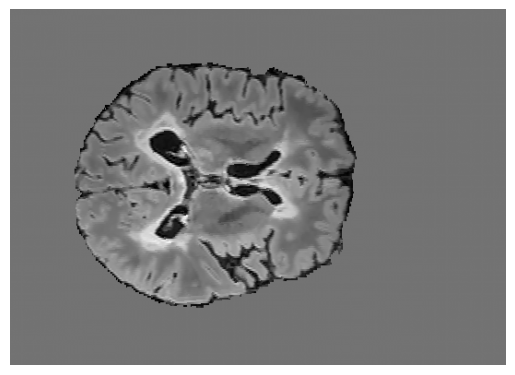

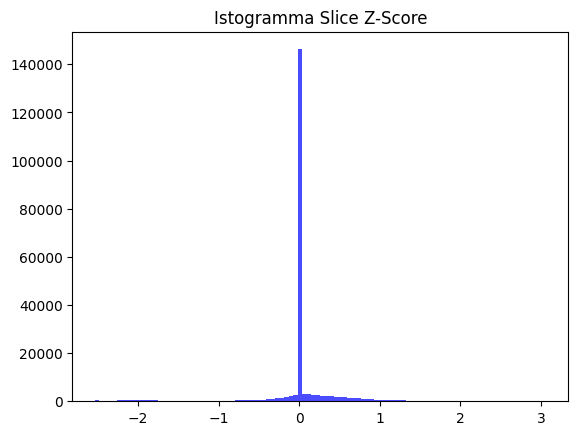

In [4]:

# Percorso al file NIfTI di input
input_file = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANiiZscore\center_01_sub_01_FLAIR_preprocessed_zscore.nii" # <-- Cambia con il percorso reale

img_3 = nib.load(input_file)
data = img_3.get_fdata()
print(data.shape)
header_img = img_3.header
print(header_img)


slice_index_2 = 330
slice_data_1 = data[:, :, slice_index_2]

# Visualizza la slice
plt.imshow(slice_data_1, cmap='gray', interpolation='bilinear')
plt.axis('off')  # Nasconde gli assi
plt.show()

plt.hist(slice_data_1.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Istogramma Slice Z-Score")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(resampled_slice[resampled_slice_mask].flatten(), bins=100)
plt.title('Histogram: Original Slice')

plt.subplot(1, 2, 2)
plt.hist(z_score.flatten(), bins=100)
plt.title('Histogram: Z-score Slice')

plt.tight_layout()
plt.show()


In [ ]:
# NORMALIZZAZIONE Z-SCORE

import os
import numpy as np
import nibabel as nib
from nibabel.processing import resample_to_output
import matplotlib.pyplot as plt

# === Parametri ===
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainBNii"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlair\TrainB_ZScore"
target_spacing = (0.5, 0.5, 0.5)

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(os.path.splitext(filename)[0])[0]

        print(f"📂 Processing: {filename}")
        img = nib.load(input_path)
        header = img.header
        voxel_spacing = header.get_zooms()  # es. (1.0, 1.0, 1.0)
        print(f"  Voxel spacing originale:", voxel_spacing)
        resampled_img = resample_to_output(img, voxel_sizes=target_spacing)
        resampled_data = resampled_img.get_fdata()
        print(f"  Nuova forma:", resampled_data.header)

        for i in range(resampled_data.shape[2]):
            slice_data = resampled_data[:, :, i]

            if np.std(slice_data) < 1e-6:
                continue

            mean = np.mean(slice_data)
            std = np.std(slice_data)
            if std < 1e-6:
                continue

            zscore = (slice_data - mean) / std
            #zscore = np.clip(zscore, -3, 3)  # opzionale: rimuove outlier estremi
            #zscore = (zscore + 3) / 6  # normalizza tra 0 e 1 per salvataggio immagine

            output_path = os.path.join(output_folder, f"{base_name}_slice{i:03d}.png")
            plt.imsave(output_path, zscore, cmap='gray')

print("✅ Completato con normalizzazione Z-score.")


In [ ]:
import nibabel as nib
import numpy as np
import os

# Percorso al file NIfTI di input
input_file = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANii\center_01_sub_01_FLAIR_preprocessed.nii" # <-- Cambia con il percorso reale

# Cartella di output
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainANiiZscore"
output_filename = os.path.basename(input_file).replace('.nii', '_zscore.nii')
output_path = os.path.join(output_folder, output_filename)

# Carica il file NIfTI
img = nib.load(input_file)
data = img.header

# Maschera per escludere lo sfondo
mask = data != 0
# Calcolo media e std solo sui voxel diversi da zero
mean = np.mean(data[mask])
std = np.std(data[mask])
print("Media e deviazione standard: ", mean, std)
# Normalizza solo i voxel != 0
z_score_data = np.zeros_like(data)
z_score_data[mask] = (data[mask] - mean) / std

# Crea e salva il nuovo file NIfTI
z_img = nib.Nifti1Image(z_score_data, affine=img.affine, header=img.header)
nib.save(z_img, output_path)

print(f"File z-score salvato in: {output_path}")


In [ ]:
import os
import numpy as np
import nibabel as nib
from nibabel.processing import resample_to_output
import matplotlib.pyplot as plt

# === Parametri ===
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainBNii"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlair\TrainB_ZScore"
target_spacing = (0.5, 0.5, 0.5)

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(os.path.splitext(filename)[0])[0]

        print(f"📂 Processing: {filename}")
        img = nib.load(input_path)
        header = img.header
        voxel_spacing = header.get_zooms()
        print(f"  Voxel spacing originale:", voxel_spacing)

        # Resampling
        resampled_img = resample_to_output(img, voxel_sizes=target_spacing)
        resampled_data = resampled_img.get_fdata()
        print("  Resampled data shape:", resampled_data.shape)

        # Calcolo Z-score su tutto il volume
        flat_data = resampled_data[resampled_data != 0]  # opzionale: escludi zeri
        mean = np.mean(flat_data)
        std = np.std(flat_data)

        if std < 1e-6:
            print(f"  ⚠️ Deviazione standard troppo piccola in {filename}, salto.")
            continue

        zscore_volume = (resampled_data - mean) / std
        zscore_volume = np.clip(zscore_volume, -3, 3)  # Rimuove outlier
        zscore_volume = (zscore_volume + 3) / 6  # Normalizza tra 0 e 1

        # Crea cartella per soggetto
        subject_output_folder = os.path.join(output_folder, base_name)
        os.makedirs(subject_output_folder, exist_ok=True)

        # Salvataggio slice per slice
        for i in range(zscore_volume.shape[2]):
            slice_data = zscore_volume[:, :, i]
            output_path = os.path.join(subject_output_folder, f"slice_{i:03d}.png")
            plt.imsave(output_path, slice_data, cmap='gray')

print("✅ Completato: normalizzazione z-score per volume e salvataggio in PNG.")


In [ ]:
# VALORI ORIGINALI
import os
import numpy as np
import nibabel as nib
from nibabel.processing import resample_to_output
import matplotlib.pyplot as plt

# === Parametri ===
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainBNii"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlair\TrainB_Original"
target_spacing = (0.5, 0.5, 0.5)

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(os.path.splitext(filename)[0])[0]

        print(f"📂 Processing: {filename}")
        img = nib.load(input_path)
        resampled_img = resample_to_output(img, voxel_sizes=target_spacing)
        resampled_data = resampled_img.get_fdata()

        for i in range(resampled_data.shape[2]):
            slice_data = resampled_data[:, :, i]

            if np.std(slice_data) < 1e-6:
                continue

            v_min, v_max = np.percentile(slice_data, (1, 99))
            if np.abs(v_max - v_min) < 1e-5:
                continue

            clipped = np.clip(slice_data, v_min, v_max)
            rescaled = (clipped - v_min) / (v_max - v_min)  # necessario per plt.imsave

            output_path = os.path.join(output_folder, f"{base_name}_slice{i:03d}.png")
            plt.imsave(output_path, rescaled, cmap='gray')

print("✅ Completato con valori non normalizzati (solo clipping).")


In [ ]:
# SALVATAGGIO IN SOTTOCARTELLE, ORIGINAL
import os
import numpy as np
import nibabel as nib
from nibabel.processing import resample_to_output
import matplotlib.pyplot as plt

# === Parametri ===
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlairNII\TrainaNii"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TrainingFlair\TrainA_Original"
target_spacing = (0.5, 0.5, 0.5)

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(os.path.splitext(filename)[0])[0]

        print(f"📂 Processing: {filename}")
        img = nib.load(input_path)
        resampled_img = resample_to_output(img, voxel_sizes=target_spacing)
        resampled_data = resampled_img.get_fdata()

        # Crea sottocartella per ogni soggetto
        subject_output_folder = os.path.join(output_folder, base_name)
        os.makedirs(subject_output_folder, exist_ok=True)

        for i in range(resampled_data.shape[2]):
            slice_data = resampled_data[:, :, i]

            if np.std(slice_data) < 1e-6:
                continue

            v_min, v_max = np.percentile(slice_data, (1, 99))
            if np.abs(v_max - v_min) < 1e-5:
                continue

            clipped = np.clip(slice_data, v_min, v_max)
            rescaled = (clipped - v_min) / (v_max - v_min)

            output_path = os.path.join(subject_output_folder, f"slice_{i:03d}.png")
            plt.imsave(output_path, rescaled, cmap='gray')

print("✅ Completato: slice salvate in sottocartelle per ogni soggetto.")


In [ ]:
# QUESTA VERSIONE PER IL MOMENTO NON TOCCARLA



import numpy as np
import nibabel as nib

import os
import matplotlib.pyplot as plt

# Impostazioni e percorsi
target_spacing = 0.5   # Obiettivo : voxel di 0.5x0.5x0.5 mm
input_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TraininigT1\TrainingT1Nii\TrainANii"
output_folder = r"C:\Users\Rosini\Desktop\ProgettoSTEFANONEW\Progetto\DatasetStefano\MSSEG-Dataset\MSSEG-Training\Training\TraininigT1\TrainingT1\TrainA"

# Processa tutti i file .nii nella cartella di input
for filename in os.listdir(input_folder):
    if filename.endswith(".nii"):
        filepath = os.path.join(input_folder, filename)
        print(f"Processing {filename}...")
        img = nib.load(filepath)
        vol = img.get_fdata()
        print(f"Forma volume originale: {vol.shape}")

        # Estrai lo spacing originale dai metadati (es. (1.1, 0.5, 0.5))
        voxel_spacing = img.header.get_zooms()
        print("Voxel spacing originale:", voxel_spacing)

        # Calcola i fattori di zoom per ottenere voxel isotropi di target_spacing mm
        zoom_x = voxel_spacing[0] / target_spacing  # es., 1.1/0.5 = 2.2
        zoom_y = voxel_spacing[1] / target_spacing  # es., 0.5/0.5 = 1.0
        zoom_z = voxel_spacing[2] / target_spacing  # es., 0.5/0.5 = 1.0
        zoom_factors = (zoom_x, zoom_y, zoom_z)
        print(f"Zoom factors: {zoom_factors}")

        # Ricampiona l'intero volume per ottenere voxel isotropi (0.5, 0.5, 0.5)
        vol_isotropic = scipy.ndimage.zoom(vol, zoom_factors, order=0)
        print(f"Forma volume isotropico: {vol_isotropic.shape}")

        # Salva ogni slice (lungo l'asse Z) del volume isotropico, ignorando quelle con dinamiche troppo estreme
        for i in range(vol_isotropic.shape[2]):
            slice_data = vol_isotropic[:, :, i]
            # Utilizza percentili (5,95) per stabilire gli estremi per il clipping
            v_min, v_max = np.percentile(slice_data, (15, 90))
            if np.abs(v_max - v_min) < 1e-6:
                print(f"Slice {i} di {filename} ha range di intensità troppo piccolo, ignorata.")
                continue
            clipped = np.clip(slice_data, v_min, v_max)
            normalized = (clipped - v_min) / (v_max - v_min)

            # Se la slice risulta estremamente uniforme, ignorala
            m = normalized.mean()
            if m < 0.06 or m > 0.95:
                print(f"Slice {i} di {filename} ha media molto estrema ({m:.2f}), ignorata.")
                continue

            # Salvataggio Immagine
            base_name = os.path.splitext(filename)[0]
            output_path = os.path.join(output_folder, f"{base_name}_slice{i}.png")
            plt.imsave(output_path, normalized, cmap='gray')
            plt.close()

print("✅ Completato!")


# Conto del numero di file nelle cartelle

In [ ]:
folders = {
    "TrainA": r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TrainA",
    "TrainB": r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TrainB",
    "TestA":  r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TestA",
    "TestB":  r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TestB"
}

for name, path in folders.items():
    count = len([f for f in os.listdir(path) if f.lower().endswith('.png')])
    print(f"{name}: {count} immagini PNG")

# Spostare il 20% dei file da una cartella all'altra
utile se si deve splittare il dataset in train e test

In [ ]:


# Cartelle originali
trainA_folder = r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TrainA"
trainB_folder = r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TrainB"

# Cartelle di destinazione
testA_folder = r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TestA"
testB_folder = r"D:\StefanoTesiMagistrale\DatasetStefano\Dataset\ANAT\TestB"

def move_percentage_of_files(src_folder, dst_folder, percentage):
    files = [f for f in os.listdir(src_folder) if f.lower().endswith('.png')]
    random.shuffle(files)
    n_to_move = int(len(files) * percentage)

    for file in files[:n_to_move]:
        src_path = os.path.join(src_folder, file)
        dst_path = os.path.join(dst_folder, file)
        shutil.move(src_path, dst_path)

    print(f"✅ Spostati {n_to_move} file da {src_folder} a {dst_folder}")

# Sposta il 20%
move_percentage_of_files(trainA_folder, testA_folder, 0.2)
#move_percentage_of_files(trainB_folder, testB_folder, 0.2)

print("✅ Operazione completata!")


# Ricostruzione da immagine PNG a file nii


In [ ]:
import os
import numpy as np
import nibabel as nib
from PIL import Image

# Cartella contenente tutte le slice PNG ordinate (es: slice_001.png, slice_002.png, ...)
folder_path = 'path_to_png_slices'
png_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])

# Carica le immagini e crea uno stack 3D
slices = []
for file in png_files:
    img = Image.open(os.path.join(folder_path, file)).convert('L')  # 'L' = grayscale
    slices.append(np.array(img))

# Stack 3D: (altezza, larghezza, numero di slice)
volume = np.stack(slices, axis=-1)

# Crea immagine NIfTI
affine = np.eye(4)  # Matrice identità (puoi sostituirla con affine reale se disponibile)
nii_img = nib.Nifti1Image(volume, affine)

# Salva
nib.save(nii_img, 'ricostruzione.nii')
